# Подготовительный этап

In [133]:
!pip install einops --quiet
!pip install timm --quiet
!pip install -q rich --quiet
!pip install -q wandb --upgrade --quiet

In [134]:
import os
import sys
import re
import gc
import platform
import random
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import einops

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import glob
import cv2

from numpy import array
from numpy import argmax

from tqdm import tqdm
from tqdm.contrib import tzip

import wandb

import warnings

warnings.simplefilter('ignore')

In [135]:
import wandb
import warnings

warnings.simplefilter('ignore')
# это только если используете wandb
# https://wandb.ai/
# если нет, то не надо
def wandb_log(**kwargs):
    """
    Logs a key-value pair to W&B
    """
    for k, v in kwargs.items():
        wandb.log({k: v})

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("my_secret_wandb")
wandb.login(key=my_secret)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [136]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="whats_the_video",
    name='baseline2'
)

In [137]:
# Настройка конфигураций
conf = dict(
    MAX_FRAMES=11,
    EPOCHS=30,
    LR=2e-4,
    IMG_SIZE=(224, 224),
    FEATURE_EXTRACTOR='resnext101_64x4d',
    DR_RATE=0.3,
    NUM_CLASSES=12,
    RNN_HIDDEN_SIZE=100,
    RNN_LAYERS=1,
    TRAIN_BS=15, # количество батчей на трейне
    VALID_BS=15, # количество батчей на валидации
    NUM_WORKERS=4, # количество процессоров которые используются
    video_train_path_csv='/kaggle/input/newwww/full_labeled_videos.csv',
    MODEL_PATH='submit/weights/model_resnext50_32x4d.pt',
    video_train_path='/kaggle/input/what-on-the-video/train',
    video_test_path='/kaggle/input/what-on-the-video/test'
    )

# Исследование данных

In [138]:
import pandas as pd
import kagglehub

# df_train = pd.read_csv('/kaggle/input/what-on-the-video/train.csv')
df_train = pd.read_csv(conf['video_train_path_csv'])
sample_submit = pd.read_csv('/kaggle/input/sample/ml_video_test.csv')

df_train.shape, sample_submit.shape

((395, 2), (435, 3))

In [139]:
df_train.head()

,video,labels
0,000692710-sunset-kathisma-beach_preview.mp4,water
1,000693013-view-toward-skyscrapers_preview.mp4,water
2,000763544-florida-boat-bay_preview.mp4,water
3,000937113-edge-sea-kilauea-lava-flow_preview.mp4,cloud
4,000939521-ecuador-crater-lake-view_preview.mp4,water


In [140]:
df_train['labels'].value_counts()

labels
water            83
cloud            52
food             45
flower           42
car              41
cloud, water     31
sunset           31
dance            30
animal           23
fire              8
water, sunset     5
cloud, sunset     3
cloud. water      1
Name: count, dtype: int64

In [141]:
df_train['labels'] = df_train['labels'].str.replace('.',',')

df_train['labels'].value_counts()

labels
water            83
cloud            52
food             45
flower           42
car              41
cloud, water     32
sunset           31
dance            30
animal           23
fire              8
water, sunset     5
cloud, sunset     3
Name: count, dtype: int64

In [142]:
print(f"Количество размеченных видео в DataFrame: {len(set(df_train['video'].values))}")
print(f"Количество видео в папке train/: {len(set(os.listdir('/kaggle/input/what-on-the-video/train')))}")

Количество размеченных видео в DataFrame: 395
Количество видео в папке train/: 428


In [143]:
import os
len(os.listdir('/kaggle/input/what-on-the-video/train'))
len(os.listdir('/kaggle/input/what-on-the-video/test'))

435

In [144]:
intersect = set(df_train['video'].values) & set(os.listdir('/kaggle/input/what-on-the-video/train'))
len(intersect)

395

# Подготовка данных

In [145]:
# Размелим датасет на обучающую и валидационную выборку, т.е. train_test_split, только самописный

df_valid = df_train.sample(frac=0.00) #берем рандомно 5% от исходного датасета
df_train = df_train[~df_train.index.isin(df_valid.index)]# теперь удалим эти 20% из исходного, это и останется на трейн

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

print(f'Train shape: {df_train.shape}')
print(f'Valid shape: {df_valid.shape}')

Train shape: (395, 2)
Valid shape: (0, 2)


In [146]:
def read_video(path, img_size, transform=None, frames_num=11):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length // (frames_num)

    current_frame = 1

    if not cap.isOpened():
        print(f"Не удалось открыть видео: {path}")
        return []

    if length == 0:
        print(f"Видео без кадров: {path}")
        return []
    for i in range(length):
        ret, frame = cap.read(current_frame)

        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # все кадры в BGR (поэтому перводим в RGB)
            frame = cv2.resize(frame, img_size)

            frames.append(frame)
            current_frame += N

    cap.release()

    return frames

example_path = '/kaggle/input/what-on-the-video/test/000691821-mexico-puerto-vallarta-ocean_preview.mp4'
example_video = read_video(path=example_path, img_size=conf['IMG_SIZE'], transform=None, frames_num=11)
len(example_video), example_video[0].shape

(11, (224, 224, 3))

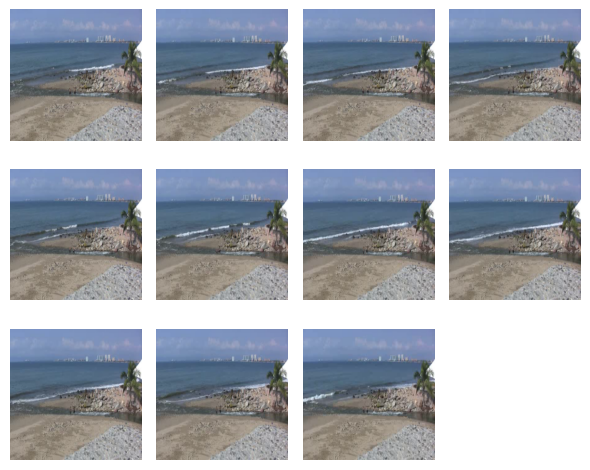

In [147]:
import matplotlib.pyplot as plt

n = len(example_video)
cols = 4  # Кол-во колонок в гриде
rows = (n + cols - 1) // cols  # Вычисляем нужное кол-во строк

plt.figure(figsize=(6, 5))
for i, img in enumerate(example_video):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img) 
    plt.axis('off')

plt.tight_layout()
plt.show()

In [148]:
unique_labels = df_train['labels'].unique()
classes = {label: idx for idx, label in enumerate(unique_labels)}
classes

{'water': 0,
 'cloud': 1,
 'flower': 2,
 'cloud, water': 3,
 'car': 4,
 'water, sunset': 5,
 'animal': 6,
 'cloud, sunset': 7,
 'sunset': 8,
 'food': 9,
 'fire': 10,
 'dance': 11}

In [149]:
class RSNADataset(Dataset):
    # def __init__ - конструктор класс
    def __init__(self, df,  conf, is_test=False):
        self.conf = conf
        self.df = df
        self.transform = A.Compose([
            A.Normalize(),
            # ToTensorV2(p=1.0),
        ],p=1.)

        self.is_test = is_test
        self.samples = []
        # Создаём словарь: класс -> индекс
        self.cls = {'cloud': 0, 'water': 1, 'sunset': 2, 'flower': 3, 'car': 4, 'food': 5,
                    'cloud, water': 6, 'animal': 7, 'dance': 8, 'fire': 9,
                    'cloud, sunset': 10, 'water, sunset': 11}

        if is_test:
            for path, label in tzip(df.path, df.labels):
                # read_video(путь, размер, кол-во кадров)
                frames = read_video(self.conf['video_test_path'] + f'/{path}',
                                    self.conf['IMG_SIZE'],
                                    self.conf['MAX_FRAMES'])

                if frames == []:
                        continue
                    
                self.samples +=[{'label': self.cls[str(label)],'frames': frames}]
        else:
            for path, label in tzip(df.video, df.labels):
                # read_video(путь, размер, кол-во кадров)
                frames = read_video(self.conf['video_train_path'] + f'/{path}',
                                    self.conf['IMG_SIZE'],
                                    self.conf['MAX_FRAMES'])
                if frames == []:
                    continue
                
                self.samples +=[{'label': self.cls[str(label)],'frames': frames}]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        frames = sample['frames']
        # print(len(frames), frames[0].shape)

        # for i in range(len(frames)):
        #     frames[i] = frames[i] / 255.0

        # if self.transform is not None:
        #     for i in range(len(frames)):
        #         frames[i] = self.transform(image=np.array(frames[i]))['image']

        # torch.from_numpy - перевод в тензоры
        # print(torch.from_numpy(frames, axis=2).shape)
        # print(torch.from_numpy(np.stack(frames, axis=2)).shape)
        if len(frames) == 0:
            print(f"No frames found for index {idx}.")
        # Handle the situation: return a default tensor or raise an error
            return 11, [11, 3, 224, 224]  # or some other appropriate default value
        frames_tr = torch.from_numpy(np.stack(frames, axis=2)).permute(2, 3, 0, 1)
        print(frames_tr.shape)
        if self.is_test:
            return frames_tr
        else:
            label = torch.tensor(sample['label']).long()
            return frames_tr, label

In [150]:
%%time

train_data = RSNADataset(df_train, conf)

train_loader = DataLoader(
        train_data,
        batch_size=conf['TRAIN_BS'],
        shuffle=False
    )

valid_data = RSNADataset(df_valid, conf)

valid_loader = DataLoader(
        valid_data,
        batch_size=conf['VALID_BS'],
        shuffle=False
    )

  0%|          | 0/395 [00:00<?, ?it/s]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x361f8e40] moov atom not found


Не удалось открыть видео: /kaggle/input/what-on-the-video/train/Humming_Bird_1_preview.mp4


0it [00:00, ?it/s]

CPU times: user 1min 46s, sys: 15.2 s, total: 2min 1s
Wall time: 47.1 s


In [151]:
for frames_tr, label in train_loader:
    print(frames_tr.shape)
    print(label.shape)
    break

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([15, 11, 3, 224, 224])
torch.Size([15])


In [152]:
print(f'Sample len (это эквивалентно количество видео): {len(train_data.samples)}') # всего в датасете 522 видео
print(f'Что лежит в одном видео: {len(train_data.samples[0])}') # в каждом видео лежат два ключа
print(f'Какие ключи: {train_data.samples[0].keys()}')# в каждом видео лежат два ключа
print(f'Что лежит в ключе labels: {train_data.samples[0]["label"]}')# ключ label
print(f'размерность данных по ключу frames: {len(train_data.samples[0]["frames"])}')# лежит 6, так как кадров из видео 6
print(f'Размерность одного кадра, frame: {train_data.samples[0]["frames"][0].shape}') # что лежит в одном кадре, его размерность

Sample len (это эквивалентно количество видео): 394
Что лежит в одном видео: 2
Какие ключи: dict_keys(['label', 'frames'])
Что лежит в ключе labels: 1
размерность данных по ключу frames: 11
Размерность одного кадра, frame: (224, 224, 3)


# Подготовка модели

In [153]:
## Model Class

class ResNextModel(nn.Module):
    def __init__(self, conf):
        super(ResNextModel, self).__init__()
        self.conf = conf
        self.backbone = timm.create_model(self.conf['FEATURE_EXTRACTOR'],
                                          pretrained=True)

    def forward(self, x):
        return self.backbone(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class RSNAModel(nn.Module):
    def __init__(self, conf, pretrained=True):
        super(RSNAModel, self).__init__()
        self.conf = conf
        self.backbone = ResNextModel(self.conf)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.num_features = self.backbone.backbone.fc.in_features

        self.backbone.backbone.fc = Identity()
        self.dropout = nn.Dropout(self.conf['DR_RATE'])
        self.rnn = nn.LSTM(self.num_features, self.conf['RNN_HIDDEN_SIZE'],
                           self.conf['RNN_LAYERS'], dropout=0.1,
                           batch_first=True, bidirectional=True)  # bidirectional=True
        self.fc1 = nn.Linear(self.conf['RNN_HIDDEN_SIZE'] * 2, self.conf['NUM_CLASSES']) #выходной слой

    def forward(self, x):
        b, f, c, h, w = x.shape
        # print(x.reshape(b * f, c, h, w).shape)
        x = self.backbone(x.reshape(b * f, c, h, w))
        # print(x.shape)
        x = x.reshape(b, f, self.num_features)
        # print(x.shape)
        x, _ = self.rnn(x)
        # print(x.shape)
        x = self.dropout(x[:, -1])  #
        # print(x.shape, self.num_features)
        x = self.fc1(x)
        return x

In [154]:
def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Trains model for one epoch
    """
    model.train()
    running_loss = 0
    # for i in tqdm([]))
    prog_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch, (frames, targets) in prog_bar:
        optimizer.zero_grad()

        frames = frames.to(device, torch.float)
        targets = targets.to(device)

        # # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"loss: {loss_item:.4f}")

        if log_wandb == True:
            wandb.log({'batch_train_loss': loss_item})
        if verbose == True and batch % 20 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_loss = running_loss / len(train_dataloader)

    return avg_loss

@torch.no_grad()
# def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
def valid_one_epoch(model, valid_dataloader, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Validates the model for one epoch
    """
    model.eval()
    running_loss = 0
    prog_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to(device, torch.float)
        targets = targets.to(device)

        # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"val_loss: {loss_item:.4f}")

        if log_wandb == True:
            wandb.log({'batch_val_loss': loss_item})

        if verbose == True and batch % 10 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_val_loss = running_loss / len(valid_dataloader)

    return avg_val_loss

In [155]:
def main(conf, train_loader, output_path, device, valid_loader=None):
    model = RSNAModel(conf)
    model = model.to(device)

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=conf['LR'])

    train_loss_fn = nn.CrossEntropyLoss()
    # valid_loss_fn = nn.CrossEntropyLoss()

    print(f"\nUsing Backbone: {conf['FEATURE_EXTRACTOR']}")

    current_loss = 1000
    for epoch in range(conf['EPOCHS']):
        print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")

        train_loss = train_one_epoch(model,
                                     train_loader,
                                     optimizer,
                                     train_loss_fn,
                                     epoch=epoch, device=device, log_wandb=log_wandb)

        # valid_loss = valid_one_epoch(model,
        #                              valid_loader,
        #                              valid_loss_fn,
        #                              epoch=epoch, device=device, log_wandb=log_wandb)
        # print(f"val_loss: {valid_loss:.4f}")

        if log_wandb == True:
            wandb_log(
                    train_loss=train_loss
                    # valid_loss=valid_loss
            )

        if train_loss < current_loss:
            current_loss = train_loss
            torch.save(model.state_dict(), f"model_{conf['FEATURE_EXTRACTOR']}.pt")


In [156]:
%%time

# ВСЕ ЗАПУСКАЕМ
log_wandb = True

if torch.cuda.is_available():
    print("Using GPU: {}\n".format(torch.cuda.get_device_name()))
    device = torch.device('cuda')
else:
    print("\nGPU not found. Using CPU: {}\n".format(platform.processor()))
    device = torch.device('cpu')

main(conf, train_loader, 'output/', device)

Using GPU: Tesla T4


Using Backbone: resnext101_64x4d

---------------- EPOCH: 1 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.5522:   4%|▎         | 1/27 [00:02<00:55,  2.14s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4731:   7%|▋         | 2/27 [00:04<00:53,  2.13s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4133:  11%|█         | 3/27 [00:06<00:50,  2.11s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.5268:  15%|█▍        | 4/27 [00:08<00:48,  2.11s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4218:  19%|█▊        | 5/27 [00:10<00:46,  2.11s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.5367:  22%|██▏       | 6/27 [00:12<00:44,  2.11s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.5191:  26%|██▌       | 7/27 [00:14<00:42,  2.13s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3800:  30%|██▉       | 8/27 [00:17<00:40,  2.15s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3052:  33%|███▎      | 9/27 [00:19<00:38,  2.14s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2499:  37%|███▋      | 10/27 [00:21<00:36,  2.14s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3817:  41%|████      | 11/27 [00:23<00:34,  2.14s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1461:  44%|████▍     | 12/27 [00:25<00:32,  2.15s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2707:  48%|████▊     | 13/27 [00:27<00:30,  2.17s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2646:  52%|█████▏    | 14/27 [00:30<00:28,  2.18s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1939:  56%|█████▌    | 15/27 [00:32<00:26,  2.19s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2840:  59%|█████▉    | 16/27 [00:34<00:24,  2.19s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4757:  63%|██████▎   | 17/27 [00:36<00:21,  2.19s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.6870:  67%|██████▋   | 18/27 [00:38<00:19,  2.20s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4164:  70%|███████   | 19/27 [00:41<00:17,  2.21s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3995:  74%|███████▍  | 20/27 [00:43<00:15,  2.22s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3834:  78%|███████▊  | 21/27 [00:45<00:13,  2.22s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2748:  81%|████████▏ | 22/27 [00:47<00:11,  2.20s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4533:  85%|████████▌ | 23/27 [00:49<00:08,  2.20s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3980:  89%|████████▉ | 24/27 [00:52<00:06,  2.20s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.5556:  93%|█████████▎| 25/27 [00:54<00:04,  2.21s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.7356:  96%|█████████▋| 26/27 [00:56<00:02,  2.23s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2261: 100%|██████████| 27/27 [00:57<00:00,  2.12s/it]



---------------- EPOCH: 2 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1594:   4%|▎         | 1/27 [00:02<00:57,  2.23s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0126:   7%|▋         | 2/27 [00:04<00:55,  2.22s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0171:  11%|█         | 3/27 [00:06<00:53,  2.22s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3283:  15%|█▍        | 4/27 [00:08<00:51,  2.22s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2740:  19%|█▊        | 5/27 [00:11<00:48,  2.22s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4837:  22%|██▏       | 6/27 [00:13<00:46,  2.23s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3960:  26%|██▌       | 7/27 [00:15<00:45,  2.25s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1010:  30%|██▉       | 8/27 [00:17<00:43,  2.27s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0597:  33%|███▎      | 9/27 [00:20<00:40,  2.27s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9289:  37%|███▋      | 10/27 [00:22<00:38,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0929:  41%|████      | 11/27 [00:24<00:36,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8491:  44%|████▍     | 12/27 [00:27<00:34,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0111:  48%|████▊     | 13/27 [00:29<00:31,  2.27s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0923:  52%|█████▏    | 14/27 [00:31<00:29,  2.27s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0959:  56%|█████▌    | 15/27 [00:33<00:27,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1179:  59%|█████▉    | 16/27 [00:36<00:25,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3535:  63%|██████▎   | 17/27 [00:38<00:22,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4447:  67%|██████▋   | 18/27 [00:40<00:20,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1958:  70%|███████   | 19/27 [00:43<00:18,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2635:  74%|███████▍  | 20/27 [00:45<00:15,  2.27s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3061:  78%|███████▊  | 21/27 [00:47<00:13,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1346:  81%|████████▏ | 22/27 [00:49<00:11,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1777:  85%|████████▌ | 23/27 [00:52<00:09,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2305:  89%|████████▉ | 24/27 [00:54<00:06,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4248:  93%|█████████▎| 25/27 [00:56<00:04,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4526:  96%|█████████▋| 26/27 [00:59<00:02,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0381: 100%|██████████| 27/27 [00:59<00:00,  2.21s/it]



---------------- EPOCH: 3 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9734:   4%|▎         | 1/27 [00:02<00:59,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8556:   7%|▋         | 2/27 [00:04<00:57,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9045:  11%|█         | 3/27 [00:06<00:55,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3329:  15%|█▍        | 4/27 [00:09<00:52,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1567:  19%|█▊        | 5/27 [00:11<00:50,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4791:  22%|██▏       | 6/27 [00:13<00:48,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2840:  26%|██▌       | 7/27 [00:16<00:46,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8937:  30%|██▉       | 8/27 [00:18<00:44,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9960:  33%|███▎      | 9/27 [00:20<00:41,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8941:  37%|███▋      | 10/27 [00:23<00:39,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9397:  41%|████      | 11/27 [00:25<00:37,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8093:  44%|████▍     | 12/27 [00:27<00:34,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7947:  48%|████▊     | 13/27 [00:30<00:32,  2.31s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8936:  52%|█████▏    | 14/27 [00:32<00:29,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8664:  56%|█████▌    | 15/27 [00:34<00:27,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0524:  59%|█████▉    | 16/27 [00:36<00:25,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3195:  63%|██████▎   | 17/27 [00:39<00:23,  2.31s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3331:  67%|██████▋   | 18/27 [00:41<00:20,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0618:  70%|███████   | 19/27 [00:43<00:18,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0658:  74%|███████▍  | 20/27 [00:46<00:16,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1713:  78%|███████▊  | 21/27 [00:48<00:13,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0122:  81%|████████▏ | 22/27 [00:50<00:11,  2.31s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0715:  85%|████████▌ | 23/27 [00:53<00:09,  2.33s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1039:  89%|████████▉ | 24/27 [00:55<00:07,  2.34s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.3260:  93%|█████████▎| 25/27 [00:57<00:04,  2.33s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.4236:  96%|█████████▋| 26/27 [01:00<00:02,  2.33s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7612: 100%|██████████| 27/27 [01:00<00:00,  2.25s/it]



---------------- EPOCH: 4 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8629:   4%|▎         | 1/27 [00:02<01:00,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7141:   7%|▋         | 2/27 [00:04<00:58,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7402:  11%|█         | 3/27 [00:06<00:55,  2.33s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2080:  15%|█▍        | 4/27 [00:09<00:53,  2.33s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0032:  19%|█▊        | 5/27 [00:11<00:51,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2414:  22%|██▏       | 6/27 [00:14<00:49,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0758:  26%|██▌       | 7/27 [00:16<00:47,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7092:  30%|██▉       | 8/27 [00:18<00:44,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7559:  33%|███▎      | 9/27 [00:21<00:42,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6281:  37%|███▋      | 10/27 [00:23<00:39,  2.34s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7452:  41%|████      | 11/27 [00:25<00:37,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6290:  44%|████▍     | 12/27 [00:28<00:35,  2.37s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6851:  48%|████▊     | 13/27 [00:30<00:33,  2.37s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7933:  52%|█████▏    | 14/27 [00:32<00:30,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7292:  56%|█████▌    | 15/27 [00:35<00:28,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8583:  59%|█████▉    | 16/27 [00:37<00:25,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0352:  63%|██████▎   | 17/27 [00:40<00:23,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1284:  67%|██████▋   | 18/27 [00:42<00:21,  2.39s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9062:  70%|███████   | 19/27 [00:44<00:19,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9629:  74%|███████▍  | 20/27 [00:47<00:16,  2.37s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0990:  78%|███████▊  | 21/27 [00:49<00:14,  2.37s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9268:  81%|████████▏ | 22/27 [00:51<00:11,  2.37s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8894:  85%|████████▌ | 23/27 [00:54<00:09,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8596:  89%|████████▉ | 24/27 [00:56<00:07,  2.39s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.2601:  93%|█████████▎| 25/27 [00:59<00:04,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.1601:  96%|█████████▋| 26/27 [01:01<00:02,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5453: 100%|██████████| 27/27 [01:02<00:00,  2.30s/it]



---------------- EPOCH: 5 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5986:   4%|▎         | 1/27 [00:02<01:01,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5548:   7%|▋         | 2/27 [00:04<00:59,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4983:  11%|█         | 3/27 [00:07<00:56,  2.36s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0211:  15%|█▍        | 4/27 [00:09<00:54,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7620:  19%|█▊        | 5/27 [00:11<00:52,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0708:  22%|██▏       | 6/27 [00:14<00:50,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9367:  26%|██▌       | 7/27 [00:16<00:47,  2.39s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4273:  30%|██▉       | 8/27 [00:19<00:45,  2.39s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6503:  33%|███▎      | 9/27 [00:21<00:42,  2.38s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4833:  37%|███▋      | 10/27 [00:23<00:40,  2.39s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4771:  41%|████      | 11/27 [00:26<00:38,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4224:  44%|████▍     | 12/27 [00:28<00:36,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4946:  48%|████▊     | 13/27 [00:31<00:33,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5781:  52%|█████▏    | 14/27 [00:33<00:31,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4989:  56%|█████▌    | 15/27 [00:36<00:29,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7236:  59%|█████▉    | 16/27 [00:38<00:26,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8799:  63%|██████▎   | 17/27 [00:40<00:24,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0818:  67%|██████▋   | 18/27 [00:43<00:21,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6975:  70%|███████   | 19/27 [00:45<00:19,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7953:  74%|███████▍  | 20/27 [00:48<00:16,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9155:  78%|███████▊  | 21/27 [00:50<00:14,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7305:  81%|████████▏ | 22/27 [00:52<00:12,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6817:  85%|████████▌ | 23/27 [00:55<00:09,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6838:  89%|████████▉ | 24/27 [00:57<00:07,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 2.0796:  93%|█████████▎| 25/27 [01:00<00:04,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9660:  96%|█████████▋| 26/27 [01:02<00:02,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2964: 100%|██████████| 27/27 [01:03<00:00,  2.34s/it]



---------------- EPOCH: 6 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4934:   4%|▎         | 1/27 [00:02<01:02,  2.39s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3265:   7%|▋         | 2/27 [00:04<01:00,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3921:  11%|█         | 3/27 [00:07<00:57,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8604:  15%|█▍        | 4/27 [00:09<00:55,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4581:  19%|█▊        | 5/27 [00:12<00:53,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8662:  22%|██▏       | 6/27 [00:14<00:50,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7506:  26%|██▌       | 7/27 [00:16<00:48,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2357:  30%|██▉       | 8/27 [00:19<00:45,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5149:  33%|███▎      | 9/27 [00:21<00:43,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3753:  37%|███▋      | 10/27 [00:24<00:41,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3884:  41%|████      | 11/27 [00:26<00:38,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2119:  44%|████▍     | 12/27 [00:28<00:36,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3562:  48%|████▊     | 13/27 [00:31<00:33,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6150:  52%|█████▏    | 14/27 [00:33<00:31,  2.40s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3892:  56%|█████▌    | 15/27 [00:36<00:28,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6177:  59%|█████▉    | 16/27 [00:38<00:26,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7422:  63%|██████▎   | 17/27 [00:41<00:24,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8892:  67%|██████▋   | 18/27 [00:43<00:21,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5068:  70%|███████   | 19/27 [00:45<00:19,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5888:  74%|███████▍  | 20/27 [00:48<00:16,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6999:  78%|███████▊  | 21/27 [00:50<00:14,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5458:  81%|████████▏ | 22/27 [00:53<00:12,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4619:  85%|████████▌ | 23/27 [00:55<00:09,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5553:  89%|████████▉ | 24/27 [00:57<00:07,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9462:  93%|█████████▎| 25/27 [01:00<00:04,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.9726:  96%|█████████▋| 26/27 [01:02<00:02,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1294: 100%|██████████| 27/27 [01:03<00:00,  2.35s/it]



---------------- EPOCH: 7 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4267:   4%|▎         | 1/27 [00:02<01:02,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1926:   7%|▋         | 2/27 [00:04<01:00,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0941:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.8022:  15%|█▍        | 4/27 [00:09<00:55,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4574:  19%|█▊        | 5/27 [00:12<00:53,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6970:  22%|██▏       | 6/27 [00:14<00:51,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5124:  26%|██▌       | 7/27 [00:17<00:48,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1000:  30%|██▉       | 8/27 [00:19<00:46,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3118:  33%|███▎      | 9/27 [00:21<00:43,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2855:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1200:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0065:  44%|████▍     | 12/27 [00:29<00:36,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1331:  48%|████▊     | 13/27 [00:31<00:34,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2921:  52%|█████▏    | 14/27 [00:34<00:31,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1628:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4026:  59%|█████▉    | 16/27 [00:38<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6339:  63%|██████▎   | 17/27 [00:41<00:24,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7048:  67%|██████▋   | 18/27 [00:43<00:21,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2755:  70%|███████   | 19/27 [00:46<00:19,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5837:  74%|███████▍  | 20/27 [00:48<00:16,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5492:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4379:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3021:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3115:  89%|████████▉ | 24/27 [00:58<00:07,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.7489:  93%|█████████▎| 25/27 [01:00<00:04,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6813:  96%|█████████▋| 26/27 [01:03<00:02,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0438: 100%|██████████| 27/27 [01:03<00:00,  2.37s/it]



---------------- EPOCH: 8 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2692:   4%|▎         | 1/27 [00:02<01:02,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0596:   7%|▋         | 2/27 [00:04<01:00,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1021:  11%|█         | 3/27 [00:07<00:58,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6143:  15%|█▍        | 4/27 [00:09<00:55,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2416:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4634:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3453:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9771:  30%|██▉       | 8/27 [00:19<00:46,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1486:  33%|███▎      | 9/27 [00:21<00:43,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0714:  37%|███▋      | 10/27 [00:24<00:41,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9997:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8968:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9720:  48%|████▊     | 13/27 [00:31<00:34,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1405:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0622:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2062:  59%|█████▉    | 16/27 [00:38<00:26,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.5036:  63%|██████▎   | 17/27 [00:41<00:24,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6439:  67%|██████▋   | 18/27 [00:43<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2424:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2624:  74%|███████▍  | 20/27 [00:48<00:17,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4333:  78%|███████▊  | 21/27 [00:51<00:14,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3627:  81%|████████▏ | 22/27 [00:53<00:12,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2415:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2136:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6075:  93%|█████████▎| 25/27 [01:00<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.6190:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8288: 100%|██████████| 27/27 [01:04<00:00,  2.37s/it]



---------------- EPOCH: 9 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0253:   4%|▎         | 1/27 [00:02<01:02,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8764:   7%|▋         | 2/27 [00:04<01:00,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8836:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4291:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0750:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2281:  22%|██▏       | 6/27 [00:14<00:50,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1158:  26%|██▌       | 7/27 [00:17<00:48,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8697:  30%|██▉       | 8/27 [00:19<00:46,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9951:  33%|███▎      | 9/27 [00:21<00:43,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9686:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7455:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8335:  44%|████▍     | 12/27 [00:29<00:36,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8923:  48%|████▊     | 13/27 [00:31<00:34,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0957:  52%|█████▏    | 14/27 [00:34<00:31,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7405:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1745:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3320:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4710:  67%|██████▋   | 18/27 [00:43<00:21,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0629:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1825:  74%|███████▍  | 20/27 [00:48<00:17,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2250:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1993:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0557:  85%|████████▌ | 23/27 [00:56<00:09,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0193:  89%|████████▉ | 24/27 [00:58<00:07,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4716:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.4499:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6246: 100%|██████████| 27/27 [01:04<00:00,  2.37s/it]



---------------- EPOCH: 10 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9045:   4%|▎         | 1/27 [00:02<01:03,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7918:   7%|▋         | 2/27 [00:04<01:01,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8207:  11%|█         | 3/27 [00:07<00:58,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3143:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8568:  19%|█▊        | 5/27 [00:12<00:53,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0791:  22%|██▏       | 6/27 [00:14<00:51,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9988:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7027:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9154:  33%|███▎      | 9/27 [00:21<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8822:  37%|███▋      | 10/27 [00:24<00:41,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7158:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7734:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8286:  48%|████▊     | 13/27 [00:31<00:34,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9410:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7275:  56%|█████▌    | 15/27 [00:36<00:29,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0444:  59%|█████▉    | 16/27 [00:39<00:27,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2501:  63%|██████▎   | 17/27 [00:41<00:24,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3718:  67%|██████▋   | 18/27 [00:44<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7831:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0545:  74%|███████▍  | 20/27 [00:48<00:17,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1459:  78%|███████▊  | 21/27 [00:51<00:14,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1670:  81%|████████▏ | 22/27 [00:53<00:12,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9058:  85%|████████▌ | 23/27 [00:56<00:09,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9294:  89%|████████▉ | 24/27 [00:58<00:07,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3251:  93%|█████████▎| 25/27 [01:01<00:04,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.3483:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4382: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 11 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7323:   4%|▎         | 1/27 [00:02<01:03,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6376:   7%|▋         | 2/27 [00:04<01:01,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7082:  11%|█         | 3/27 [00:07<00:58,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2244:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7192:  19%|█▊        | 5/27 [00:12<00:54,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0609:  22%|██▏       | 6/27 [00:14<00:51,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8537:  26%|██▌       | 7/27 [00:17<00:49,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5938:  30%|██▉       | 8/27 [00:19<00:46,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8259:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7444:  37%|███▋      | 10/27 [00:24<00:41,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5321:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5877:  44%|████▍     | 12/27 [00:29<00:36,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6067:  48%|████▊     | 13/27 [00:31<00:34,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8093:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6033:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9353:  59%|█████▉    | 16/27 [00:39<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9985:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1904:  67%|██████▋   | 18/27 [00:44<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6980:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9085:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9820:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9937:  81%|████████▏ | 22/27 [00:53<00:12,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6916:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8227:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2016:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.2678:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4358: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 12 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6550:   4%|▎         | 1/27 [00:02<01:02,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6875:   7%|▋         | 2/27 [00:04<01:00,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5995:  11%|█         | 3/27 [00:07<00:58,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0550:  15%|█▍        | 4/27 [00:09<00:55,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6436:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7954:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7703:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5080:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6595:  33%|███▎      | 9/27 [00:21<00:43,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6519:  37%|███▋      | 10/27 [00:24<00:41,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4906:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5829:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5036:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7180:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5809:  56%|█████▌    | 15/27 [00:36<00:29,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8748:  59%|█████▉    | 16/27 [00:38<00:26,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9417:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1007:  67%|██████▋   | 18/27 [00:43<00:22,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5687:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9091:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9816:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8909:  81%|████████▏ | 22/27 [00:53<00:12,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5593:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7135:  89%|████████▉ | 24/27 [00:58<00:07,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0378:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.1896:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3663: 100%|██████████| 27/27 [01:04<00:00,  2.37s/it]



---------------- EPOCH: 13 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5169:   4%|▎         | 1/27 [00:02<01:03,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6203:   7%|▋         | 2/27 [00:04<01:01,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5639:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0096:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6347:  19%|█▊        | 5/27 [00:12<00:54,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6816:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6386:  26%|██▌       | 7/27 [00:17<00:48,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4354:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6597:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5969:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4181:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5737:  44%|████▍     | 12/27 [00:29<00:36,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5261:  48%|████▊     | 13/27 [00:31<00:34,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7109:  52%|█████▏    | 14/27 [00:34<00:31,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4033:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7399:  59%|█████▉    | 16/27 [00:39<00:27,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8672:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9716:  67%|██████▋   | 18/27 [00:44<00:21,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4798:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7937:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8369:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8183:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5742:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7571:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9016:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 1.0220:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2558: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 14 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4695:   4%|▎         | 1/27 [00:02<01:03,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4706:   7%|▋         | 2/27 [00:04<01:01,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4699:  11%|█         | 3/27 [00:07<00:59,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8764:  15%|█▍        | 4/27 [00:09<00:56,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4168:  19%|█▊        | 5/27 [00:12<00:53,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5913:  22%|██▏       | 6/27 [00:14<00:51,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6049:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3961:  30%|██▉       | 8/27 [00:19<00:46,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4886:  33%|███▎      | 9/27 [00:22<00:43,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6157:  37%|███▋      | 10/27 [00:24<00:41,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3488:  41%|████      | 11/27 [00:26<00:39,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5068:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4092:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5626:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3771:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6685:  59%|█████▉    | 16/27 [00:39<00:27,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7615:  63%|██████▎   | 17/27 [00:41<00:24,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7321:  67%|██████▋   | 18/27 [00:44<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4089:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6112:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7167:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6751:  81%|████████▏ | 22/27 [00:53<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4247:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6511:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.9284:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8906:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2437: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 15 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4038:   4%|▎         | 1/27 [00:02<01:03,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4471:   7%|▋         | 2/27 [00:04<01:01,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4290:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7548:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4144:  19%|█▊        | 5/27 [00:12<00:54,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5378:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4847:  26%|██▌       | 7/27 [00:17<00:48,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2983:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5096:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4776:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2657:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5106:  44%|████▍     | 12/27 [00:29<00:36,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3791:  48%|████▊     | 13/27 [00:31<00:34,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4935:  52%|█████▏    | 14/27 [00:34<00:31,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3523:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5745:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6036:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8309:  67%|██████▋   | 18/27 [00:44<00:21,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4725:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4958:  74%|███████▍  | 20/27 [00:48<00:17,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6094:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6490:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3850:  85%|████████▌ | 23/27 [00:56<00:09,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5765:  89%|████████▉ | 24/27 [00:58<00:07,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7052:  93%|█████████▎| 25/27 [01:01<00:04,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.8102:  96%|█████████▋| 26/27 [01:03<00:02,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1862: 100%|██████████| 27/27 [01:04<00:00,  2.37s/it]



---------------- EPOCH: 16 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4143:   4%|▎         | 1/27 [00:02<01:03,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3194:   7%|▋         | 2/27 [00:04<01:01,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3876:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6565:  15%|█▍        | 4/27 [00:09<00:55,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2924:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3938:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4653:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2808:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4527:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4124:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2218:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3707:  44%|████▍     | 12/27 [00:29<00:36,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3003:  48%|████▊     | 13/27 [00:31<00:34,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4113:  52%|█████▏    | 14/27 [00:34<00:31,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3160:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4738:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5370:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7056:  67%|██████▋   | 18/27 [00:43<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3693:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4911:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5771:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5621:  81%|████████▏ | 22/27 [00:53<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3819:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5887:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6475:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7114:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1888: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 17 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3494:   4%|▎         | 1/27 [00:02<01:03,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3775:   7%|▋         | 2/27 [00:04<01:00,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3591:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5848:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2943:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4103:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3888:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2378:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4110:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3571:  37%|███▋      | 10/27 [00:24<00:41,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1922:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4292:  44%|████▍     | 12/27 [00:29<00:36,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2846:  48%|████▊     | 13/27 [00:31<00:34,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2980:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2771:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3730:  59%|█████▉    | 16/27 [00:39<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5032:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6396:  67%|██████▋   | 18/27 [00:44<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3262:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4936:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4910:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4668:  81%|████████▏ | 22/27 [00:53<00:12,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3233:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3963:  89%|████████▉ | 24/27 [00:58<00:07,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6284:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7241:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1525: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 18 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2783:   4%|▎         | 1/27 [00:02<01:03,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2825:   7%|▋         | 2/27 [00:04<01:01,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2593:  11%|█         | 3/27 [00:07<00:58,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4745:  15%|█▍        | 4/27 [00:09<00:56,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3073:  19%|█▊        | 5/27 [00:12<00:53,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3376:  22%|██▏       | 6/27 [00:14<00:51,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3612:  26%|██▌       | 7/27 [00:17<00:48,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2087:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3504:  33%|███▎      | 9/27 [00:22<00:44,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2773:  37%|███▋      | 10/27 [00:24<00:41,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2158:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3631:  44%|████▍     | 12/27 [00:29<00:36,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3161:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2994:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2455:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3833:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4569:  63%|██████▎   | 17/27 [00:41<00:24,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5762:  67%|██████▋   | 18/27 [00:44<00:21,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2585:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3717:  74%|███████▍  | 20/27 [00:48<00:17,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5102:  78%|███████▊  | 21/27 [00:51<00:14,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4735:  81%|████████▏ | 22/27 [00:53<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3515:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3885:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5307:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.7211:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1095: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 19 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2741:   4%|▎         | 1/27 [00:02<01:02,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2334:   7%|▋         | 2/27 [00:04<01:01,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2477:  11%|█         | 3/27 [00:07<00:58,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4841:  15%|█▍        | 4/27 [00:09<00:55,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2855:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3343:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3081:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2231:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3460:  33%|███▎      | 9/27 [00:21<00:43,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3051:  37%|███▋      | 10/27 [00:24<00:41,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1813:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3632:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2865:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3098:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2500:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2650:  59%|█████▉    | 16/27 [00:39<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3558:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.5389:  67%|██████▋   | 18/27 [00:43<00:22,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2738:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3073:  74%|███████▍  | 20/27 [00:48<00:17,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4223:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4047:  81%|████████▏ | 22/27 [00:53<00:12,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3722:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3973:  89%|████████▉ | 24/27 [00:58<00:07,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4395:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.6070:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1033: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 20 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2105:   4%|▎         | 1/27 [00:02<01:03,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1861:   7%|▋         | 2/27 [00:04<01:00,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1990:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3634:  15%|█▍        | 4/27 [00:09<00:55,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2267:  19%|█▊        | 5/27 [00:12<00:53,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2812:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2522:  26%|██▌       | 7/27 [00:17<00:49,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2401:  30%|██▉       | 8/27 [00:19<00:46,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2773:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2420:  37%|███▋      | 10/27 [00:24<00:41,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1565:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2586:  44%|████▍     | 12/27 [00:29<00:36,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2480:  48%|████▊     | 13/27 [00:31<00:34,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2307:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1879:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2852:  59%|█████▉    | 16/27 [00:39<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3077:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3937:  67%|██████▋   | 18/27 [00:44<00:22,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2139:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2654:  74%|███████▍  | 20/27 [00:48<00:17,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3216:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2835:  81%|████████▏ | 22/27 [00:53<00:12,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2709:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3162:  89%|████████▉ | 24/27 [00:58<00:07,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3132:  93%|█████████▎| 25/27 [01:01<00:04,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4542:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1242: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 21 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2061:   4%|▎         | 1/27 [00:02<01:03,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1646:   7%|▋         | 2/27 [00:04<01:01,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1546:  11%|█         | 3/27 [00:07<00:59,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3286:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2141:  19%|█▊        | 5/27 [00:12<00:54,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2990:  22%|██▏       | 6/27 [00:14<00:51,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2036:  26%|██▌       | 7/27 [00:17<00:49,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1506:  30%|██▉       | 8/27 [00:19<00:46,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1702:  33%|███▎      | 9/27 [00:22<00:44,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1958:  37%|███▋      | 10/27 [00:24<00:41,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1028:  41%|████      | 11/27 [00:27<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1848:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1951:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2378:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2083:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2816:  59%|█████▉    | 16/27 [00:39<00:27,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3432:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3940:  67%|██████▋   | 18/27 [00:44<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2081:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2698:  74%|███████▍  | 20/27 [00:49<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3326:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2752:  81%|████████▏ | 22/27 [00:53<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2687:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2753:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3503:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.4747:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1204: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 22 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1852:   4%|▎         | 1/27 [00:02<01:02,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1553:   7%|▋         | 2/27 [00:04<01:00,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1873:  11%|█         | 3/27 [00:07<00:58,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3403:  15%|█▍        | 4/27 [00:09<00:55,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2493:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2105:  22%|██▏       | 6/27 [00:14<00:51,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1935:  26%|██▌       | 7/27 [00:17<00:49,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1535:  30%|██▉       | 8/27 [00:19<00:46,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2001:  33%|███▎      | 9/27 [00:22<00:44,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1795:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0774:  41%|████      | 11/27 [00:26<00:39,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1837:  44%|████▍     | 12/27 [00:29<00:36,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2138:  48%|████▊     | 13/27 [00:31<00:34,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1915:  52%|█████▏    | 14/27 [00:34<00:32,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1649:  56%|█████▌    | 15/27 [00:36<00:29,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2347:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2648:  63%|██████▎   | 17/27 [00:41<00:24,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3818:  67%|██████▋   | 18/27 [00:44<00:22,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1632:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3045:  74%|███████▍  | 20/27 [00:49<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2582:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2762:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2099:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2134:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3613:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3420:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0717: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 23 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2100:   4%|▎         | 1/27 [00:02<01:02,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1700:   7%|▋         | 2/27 [00:04<01:00,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1250:  11%|█         | 3/27 [00:07<00:58,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2635:  15%|█▍        | 4/27 [00:09<00:56,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1667:  19%|█▊        | 5/27 [00:12<00:53,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1976:  22%|██▏       | 6/27 [00:14<00:51,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2300:  26%|██▌       | 7/27 [00:17<00:48,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1273:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1597:  33%|███▎      | 9/27 [00:21<00:43,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1697:  37%|███▋      | 10/27 [00:24<00:41,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0802:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1620:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1299:  48%|████▊     | 13/27 [00:31<00:34,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1333:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1467:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2129:  59%|█████▉    | 16/27 [00:39<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2371:  63%|██████▎   | 17/27 [00:41<00:24,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3213:  67%|██████▋   | 18/27 [00:44<00:22,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1427:  70%|███████   | 19/27 [00:46<00:19,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2218:  74%|███████▍  | 20/27 [00:48<00:17,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2738:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2449:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1462:  85%|████████▌ | 23/27 [00:56<00:09,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2484:  89%|████████▉ | 24/27 [00:58<00:07,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2425:  93%|█████████▎| 25/27 [01:01<00:04,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.3489:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0375: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 24 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1718:   4%|▎         | 1/27 [00:02<01:03,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1549:   7%|▋         | 2/27 [00:04<01:00,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1350:  11%|█         | 3/27 [00:07<00:58,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2072:  15%|█▍        | 4/27 [00:09<00:56,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1684:  19%|█▊        | 5/27 [00:12<00:54,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1555:  22%|██▏       | 6/27 [00:14<00:51,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2069:  26%|██▌       | 7/27 [00:17<00:49,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0998:  30%|██▉       | 8/27 [00:19<00:46,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1532:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1433:  37%|███▋      | 10/27 [00:24<00:41,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0833:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1368:  44%|████▍     | 12/27 [00:29<00:36,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1639:  48%|████▊     | 13/27 [00:31<00:34,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1296:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1298:  56%|█████▌    | 15/27 [00:36<00:29,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1372:  59%|█████▉    | 16/27 [00:39<00:26,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2157:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2614:  67%|██████▋   | 18/27 [00:44<00:22,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1293:  70%|███████   | 19/27 [00:46<00:19,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1917:  74%|███████▍  | 20/27 [00:49<00:17,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2290:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2213:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1394:  85%|████████▌ | 23/27 [00:56<00:09,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1867:  89%|████████▉ | 24/27 [00:58<00:07,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2256:  93%|█████████▎| 25/27 [01:01<00:04,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2958:  96%|█████████▋| 26/27 [01:03<00:02,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0710: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it]



---------------- EPOCH: 25 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1207:   4%|▎         | 1/27 [00:02<01:02,  2.42s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1009:   7%|▋         | 2/27 [00:04<01:00,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0963:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1779:  15%|█▍        | 4/27 [00:09<00:55,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1126:  19%|█▊        | 5/27 [00:12<00:53,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1787:  22%|██▏       | 6/27 [00:14<00:51,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1930:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1201:  30%|██▉       | 8/27 [00:19<00:46,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1365:  33%|███▎      | 9/27 [00:21<00:43,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1556:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1165:  41%|████      | 11/27 [00:26<00:39,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1301:  44%|████▍     | 12/27 [00:29<00:36,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0976:  48%|████▊     | 13/27 [00:31<00:34,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1151:  52%|█████▏    | 14/27 [00:34<00:31,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1224:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1800:  59%|█████▉    | 16/27 [00:39<00:27,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1775:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2386:  67%|██████▋   | 18/27 [00:43<00:21,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0952:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1623:  74%|███████▍  | 20/27 [00:48<00:17,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2313:  78%|███████▊  | 21/27 [00:51<00:14,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2368:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1469:  85%|████████▌ | 23/27 [00:56<00:09,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1757:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2241:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2391:  96%|█████████▋| 26/27 [01:03<00:02,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0467: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 26 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1207:   4%|▎         | 1/27 [00:02<01:02,  2.41s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1156:   7%|▋         | 2/27 [00:04<01:01,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0696:  11%|█         | 3/27 [00:07<00:58,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1743:  15%|█▍        | 4/27 [00:09<00:56,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1448:  19%|█▊        | 5/27 [00:12<00:53,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1497:  22%|██▏       | 6/27 [00:14<00:50,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1541:  26%|██▌       | 7/27 [00:17<00:48,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1002:  30%|██▉       | 8/27 [00:19<00:46,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1320:  33%|███▎      | 9/27 [00:21<00:43,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1010:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0634:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1079:  44%|████▍     | 12/27 [00:29<00:36,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0925:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1261:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0958:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1523:  59%|█████▉    | 16/27 [00:39<00:27,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1593:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1850:  67%|██████▋   | 18/27 [00:43<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1116:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1279:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2108:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1986:  81%|████████▏ | 22/27 [00:53<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1183:  85%|████████▌ | 23/27 [00:56<00:09,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1355:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2151:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2246:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0732: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 27 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1210:   4%|▎         | 1/27 [00:02<01:03,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0873:   7%|▋         | 2/27 [00:04<01:01,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0716:  11%|█         | 3/27 [00:07<00:58,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1492:  15%|█▍        | 4/27 [00:09<00:56,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0936:  19%|█▊        | 5/27 [00:12<00:54,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1151:  22%|██▏       | 6/27 [00:14<00:51,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1214:  26%|██▌       | 7/27 [00:17<00:49,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0732:  30%|██▉       | 8/27 [00:19<00:46,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1082:  33%|███▎      | 9/27 [00:22<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1014:  37%|███▋      | 10/27 [00:24<00:41,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0610:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1563:  44%|████▍     | 12/27 [00:29<00:36,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1326:  48%|████▊     | 13/27 [00:31<00:34,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0811:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1084:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1039:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1326:  63%|██████▎   | 17/27 [00:41<00:24,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1633:  67%|██████▋   | 18/27 [00:44<00:22,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0692:  70%|███████   | 19/27 [00:46<00:19,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1246:  74%|███████▍  | 20/27 [00:49<00:17,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1506:  78%|███████▊  | 21/27 [00:51<00:14,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1591:  81%|████████▏ | 22/27 [00:53<00:12,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1186:  85%|████████▌ | 23/27 [00:56<00:09,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1344:  89%|████████▉ | 24/27 [00:58<00:07,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1722:  93%|█████████▎| 25/27 [01:01<00:04,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2650:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0691: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it]



---------------- EPOCH: 28 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0939:   4%|▎         | 1/27 [00:02<01:03,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0860:   7%|▋         | 2/27 [00:04<01:00,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0563:  11%|█         | 3/27 [00:07<00:58,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1396:  15%|█▍        | 4/27 [00:09<00:55,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0913:  19%|█▊        | 5/27 [00:12<00:53,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1005:  22%|██▏       | 6/27 [00:14<00:51,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1051:  26%|██▌       | 7/27 [00:17<00:48,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0719:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0814:  33%|███▎      | 9/27 [00:21<00:44,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0552:  37%|███▋      | 10/27 [00:24<00:41,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0594:  41%|████      | 11/27 [00:26<00:39,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0872:  44%|████▍     | 12/27 [00:29<00:36,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0674:  48%|████▊     | 13/27 [00:31<00:34,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1082:  52%|█████▏    | 14/27 [00:34<00:31,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0900:  56%|█████▌    | 15/27 [00:36<00:29,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0994:  59%|█████▉    | 16/27 [00:39<00:26,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1579:  63%|██████▎   | 17/27 [00:41<00:24,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1415:  67%|██████▋   | 18/27 [00:43<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0950:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1384:  74%|███████▍  | 20/27 [00:48<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1374:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1557:  81%|████████▏ | 22/27 [00:53<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0950:  85%|████████▌ | 23/27 [00:56<00:09,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1368:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1593:  93%|█████████▎| 25/27 [01:01<00:04,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.2452:  96%|█████████▋| 26/27 [01:03<00:02,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0516: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it]



---------------- EPOCH: 29 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1013:   4%|▎         | 1/27 [00:02<01:03,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0895:   7%|▋         | 2/27 [00:04<01:01,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0597:  11%|█         | 3/27 [00:07<00:58,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1263:  15%|█▍        | 4/27 [00:09<00:56,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0880:  19%|█▊        | 5/27 [00:12<00:54,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0941:  22%|██▏       | 6/27 [00:14<00:51,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1018:  26%|██▌       | 7/27 [00:17<00:49,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0676:  30%|██▉       | 8/27 [00:19<00:46,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0870:  33%|███▎      | 9/27 [00:22<00:44,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0784:  37%|███▋      | 10/27 [00:24<00:41,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0532:  41%|████      | 11/27 [00:27<00:39,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1132:  44%|████▍     | 12/27 [00:29<00:37,  2.48s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0812:  48%|████▊     | 13/27 [00:31<00:34,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0824:  52%|█████▏    | 14/27 [00:34<00:31,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0704:  56%|█████▌    | 15/27 [00:36<00:29,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1258:  59%|█████▉    | 16/27 [00:39<00:27,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1329:  63%|██████▎   | 17/27 [00:41<00:24,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1237:  67%|██████▋   | 18/27 [00:44<00:22,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0737:  70%|███████   | 19/27 [00:46<00:19,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1266:  74%|███████▍  | 20/27 [00:49<00:17,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1095:  78%|███████▊  | 21/27 [00:51<00:14,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1398:  81%|████████▏ | 22/27 [00:54<00:12,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0953:  85%|████████▌ | 23/27 [00:56<00:09,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1059:  89%|████████▉ | 24/27 [00:58<00:07,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1430:  93%|█████████▎| 25/27 [01:01<00:04,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1646:  96%|█████████▋| 26/27 [01:03<00:02,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0416: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it]



---------------- EPOCH: 30 ----------------



  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0747:   4%|▎         | 1/27 [00:02<01:03,  2.43s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0782:   7%|▋         | 2/27 [00:04<01:01,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0572:  11%|█         | 3/27 [00:07<00:58,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1003:  15%|█▍        | 4/27 [00:09<00:56,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0652:  19%|█▊        | 5/27 [00:12<00:53,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0801:  22%|██▏       | 6/27 [00:14<00:51,  2.45s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0775:  26%|██▌       | 7/27 [00:17<00:48,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0660:  30%|██▉       | 8/27 [00:19<00:46,  2.44s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0988:  33%|███▎      | 9/27 [00:22<00:44,  2.46s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0841:  37%|███▋      | 10/27 [00:24<00:42,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0466:  41%|████      | 11/27 [00:27<00:39,  2.47s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0724:  44%|████▍     | 12/27 [00:29<00:37,  2.48s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0728:  48%|████▊     | 13/27 [00:32<00:34,  2.48s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0744:  52%|█████▏    | 14/27 [00:34<00:32,  2.49s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0550:  56%|█████▌    | 15/27 [00:37<00:30,  2.53s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0914:  59%|█████▉    | 16/27 [00:39<00:28,  2.55s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0818:  63%|██████▎   | 17/27 [00:42<00:25,  2.56s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1333:  67%|██████▋   | 18/27 [00:44<00:23,  2.58s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0768:  70%|███████   | 19/27 [00:47<00:20,  2.59s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0804:  74%|███████▍  | 20/27 [00:50<00:18,  2.61s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1316:  78%|███████▊  | 21/27 [00:52<00:15,  2.63s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1095:  81%|████████▏ | 22/27 [00:55<00:13,  2.65s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0685:  85%|████████▌ | 23/27 [00:58<00:10,  2.65s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0859:  89%|████████▉ | 24/27 [01:00<00:07,  2.64s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1287:  93%|█████████▎| 25/27 [01:03<00:05,  2.63s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.1887:  96%|█████████▋| 26/27 [01:06<00:02,  2.62s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


loss: 0.0363: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it]


CPU times: user 32min 20s, sys: 32.1 s, total: 32min 52s
Wall time: 32min 14s


In [157]:
run.finish()

batch_train_loss,█▇▇██▇▇▆▅▆▅▅▆▆▅▄▄▄▃▂▂▂▃▁▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch_train_loss,0.0363
train_loss,0.08578


In [158]:
unique_labels = df_train['labels'].unique()
classes = {label: idx for idx, label in enumerate(unique_labels)}
df_valid['labels_idx'] = df_valid['labels'].map(classes)

df_valid.head()

,video,labels,labels_idx


In [159]:
# from sklearn.metrics import accuracy_score, f1_score

# print(accuracy_score(df_valid['labels_idx'].values, df_valid['labels'].values))
# print(f1_score(df_valid['labels_idx'].values, df_valid['labels'].values, average='weighted'))

In [160]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# conf_matrix = confusion_matrix(df_valid['labels_idx'].values, df_valid['labels_pred'].values)

# sns.heatmap(conf_matrix, annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

In [161]:
df_valid

,video,labels,labels_idx


# Подготовка ответов для test

In [162]:
sample_submit.columns = ['index', 'path', 'labels']
sample_submit['labels'] = 'animal'
sample_submit

,index,path,labels
0,0,Arizona sunset with creosote bush_preview.mp4,animal
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal
3,3,Pordeitev_smrek_preview.mp4,animal
4,4,City street time lapse-H264 75_preview.mp4,animal
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [163]:
test_data = RSNADataset(sample_submit, conf, is_test=True)

test_loader = DataLoader(
        test_data,
        batch_size=7,
        shuffle=False
    )

  0%|          | 0/435 [00:00<?, ?it/s]

In [164]:
for frames in test_loader:
    print(frames.shape)
    break

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([7, 11, 3, 224, 224])


In [165]:
sample_submit

,index,path,labels
0,0,Arizona sunset with creosote bush_preview.mp4,animal
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal
3,3,Pordeitev_smrek_preview.mp4,animal
4,4,City street time lapse-H264 75_preview.mp4,animal
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [166]:
test_data = RSNADataset(sample_submit, conf, is_test=True)
test_loader = DataLoader(
        test_data,
        batch_size=conf['TRAIN_BS'],
        shuffle=False
    )

pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RSNAModel(conf).to(device)
model.load_state_dict(torch.load("/kaggle/working/model_resnext101_64x4d.pt", map_location=device))
model.eval()
model.eval()

prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
for batch, frames in prog_bar:
    # print(batch, frames.shape)
    frames = frames.to('cuda').float()
    with torch.no_grad():
        pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())



  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


  3%|▎         | 1/29 [00:02<00:59,  2.13s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


  7%|▋         | 2/29 [00:04<00:56,  2.10s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 10%|█         | 3/29 [00:06<00:54,  2.10s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 14%|█▍        | 4/29 [00:08<00:52,  2.11s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 17%|█▋        | 5/29 [00:10<00:51,  2.13s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 21%|██        | 6/29 [00:12<00:48,  2.13s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 24%|██▍       | 7/29 [00:14<00:46,  2.13s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 28%|██▊       | 8/29 [00:17<00:44,  2.14s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 31%|███       | 9/29 [00:19<00:43,  2.15s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 34%|███▍      | 10/29 [00:21<00:41,  2.16s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 38%|███▊      | 11/29 [00:23<00:39,  2.18s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 41%|████▏     | 12/29 [00:25<00:37,  2.19s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 45%|████▍     | 13/29 [00:28<00:35,  2.21s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 48%|████▊     | 14/29 [00:30<00:33,  2.23s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 52%|█████▏    | 15/29 [00:32<00:31,  2.24s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 55%|█████▌    | 16/29 [00:34<00:29,  2.25s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 59%|█████▊    | 17/29 [00:37<00:27,  2.27s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 62%|██████▏   | 18/29 [00:39<00:25,  2.28s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 66%|██████▌   | 19/29 [00:41<00:22,  2.29s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 69%|██████▉   | 20/29 [00:44<00:20,  2.30s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 72%|███████▏  | 21/29 [00:46<00:18,  2.31s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 76%|███████▌  | 22/29 [00:48<00:16,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 79%|███████▉  | 23/29 [00:51<00:13,  2.32s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 83%|████████▎ | 24/29 [00:53<00:11,  2.33s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 86%|████████▌ | 25/29 [00:55<00:09,  2.34s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 90%|████████▉ | 26/29 [00:58<00:07,  2.34s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 93%|█████████▎| 27/29 [01:00<00:04,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


 97%|█████████▋| 28/29 [01:02<00:02,  2.35s/it]

torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])
torch.Size([11, 3, 224, 224])


100%|██████████| 29/29 [01:05<00:00,  2.25s/it]


In [167]:
sample_submit['labels_pred'] = pred

In [168]:
sample_submit

,index,path,labels,labels_pred
0,0,Arizona sunset with creosote bush_preview.mp4,animal,0
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal,7
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal,5
3,3,Pordeitev_smrek_preview.mp4,animal,2
4,4,City street time lapse-H264 75_preview.mp4,animal,4
...,...,...,...,...
430,430,Sydney_storm_preview.mp4,animal,0
431,431,Alaska spring shrub in wind_preview.mp4,animal,0
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal,5
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal,1


In [169]:
my_submit = pd.read_csv('/kaggle/input/what-on-the-video/sample_submit.csv')
my_submit

,index,file_name,label
0,0,Arizona sunset with creosote bush_preview.mp4,"sunset, cloud"
1,1,_import_616e7f78a17260.13545125_preview.mp4,"sunset, cloud"
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,"sunset, cloud"
3,3,Pordeitev_smrek_preview.mp4,"sunset, cloud"
4,4,City street time lapse-H264 75_preview.mp4,"sunset, cloud"
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [170]:
sample_submit

,index,path,labels,labels_pred
0,0,Arizona sunset with creosote bush_preview.mp4,animal,0
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal,7
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal,5
3,3,Pordeitev_smrek_preview.mp4,animal,2
4,4,City street time lapse-H264 75_preview.mp4,animal,4
...,...,...,...,...
430,430,Sydney_storm_preview.mp4,animal,0
431,431,Alaska spring shrub in wind_preview.mp4,animal,0
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal,5
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal,1


In [171]:
my_submit.columns = ['index', 'file_name', 'label']
my_submit['label'] = sample_submit['labels_pred']

# my_submit['labels'] = my_submit['labels'].map(classes)
# my_submit[['index','file_name', 'labels']].to_csv('my_baseline_submit.csv', index=False)
my_submit['label'] = my_submit['label']

In [172]:
# baseline = pd.read_csv('my_baseline_submit.csv')
# baseline
my_submit['label'] = my_submit['label'].map({0: 'cloud', 1: 'water', 2: 'sunset', 3: 'flower', 4: 'car', 5: 'food',
                    6: 'cloud, water', 7: 'animal', 8: 'dance', 9: 'fire',
                    10: 'cloud, sunset', 11: 'water, sunset'})
my_submit[['index','file_name', 'label']].to_csv('my_baseline_submit.csv', index=False)

In [173]:
baseline = pd.read_csv('my_baseline_submit.csv')
baseline
# my_submit

,index,file_name,label
0,0,Arizona sunset with creosote bush_preview.mp4,cloud
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,food
3,3,Pordeitev_smrek_preview.mp4,sunset
4,4,City street time lapse-H264 75_preview.mp4,car
...,...,...,...
430,430,Sydney_storm_preview.mp4,cloud
431,431,Alaska spring shrub in wind_preview.mp4,cloud
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,food
433,433,Ireland Dingle Peninsula road above sea cliffs...,water


In [174]:
# import requests

# url = "https://example.com/file.csv"  # Замените на реальную ссылку
# response = requests.get(url)

# with open("downloaded_file.csv", "wb") as f:
#     f.write(response.content)

In [175]:
# my_submit = pd.read_csv('/kaggle/input/what-on-the-video/sample_submit.csv')
# my_submit

In [176]:
# my_submit.columns = ['index', 'file_name', 'label']
# my_submit['label'] = sample_submit['labels']

# my_submit['label'] = my_submit['label']
# my_submit[['index','file_name', 'label']].to_csv('my_baseline_submit.csv', index=False)